# Example for the homework

In [ ]:
!git clone https://github.com/DeepStudio-TW/small-data-ssl-lecture.git
%cd small-data-ssl-lecture

In [ ]:
# 升級 gdown 套件
!pip install -q --upgrade gdown
# Download dataset
!gdown -q  https://drive.google.com/uc?id=1UAeZqIDqYm4pwQEkr1iTaVuq4tOgLL2O
# Unzip the files
!tar zxf  kaggle.tar.gz

In [1]:
# 讀取基本套件
import shutil, os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
# Backend: pytorch
import torch


In [2]:
# 設一個 show data和label的function
def show_data(imgs, titles,cmap=None):
    # imshow, 縮放模式為nearest。
    plt.figure(figsize=(18, 18))
    for id,(img,title) in enumerate(zip(imgs,titles)):
        plt.subplot(1, len(titles), id+1)
        fig = plt.imshow(img,interpolation='nearest',cmap=cmap)
        plt.axis("off")
        plt.title(title)

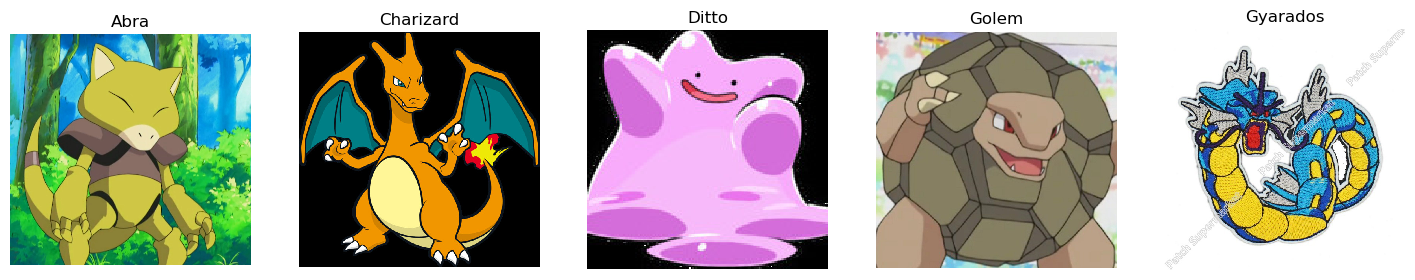

In [3]:
# 看source data: 
titles = ['Abra', 'Charizard', 'Ditto', 'Golem', 'Gyarados']
example_files=[glob(f"source/{i}/*.jpg")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

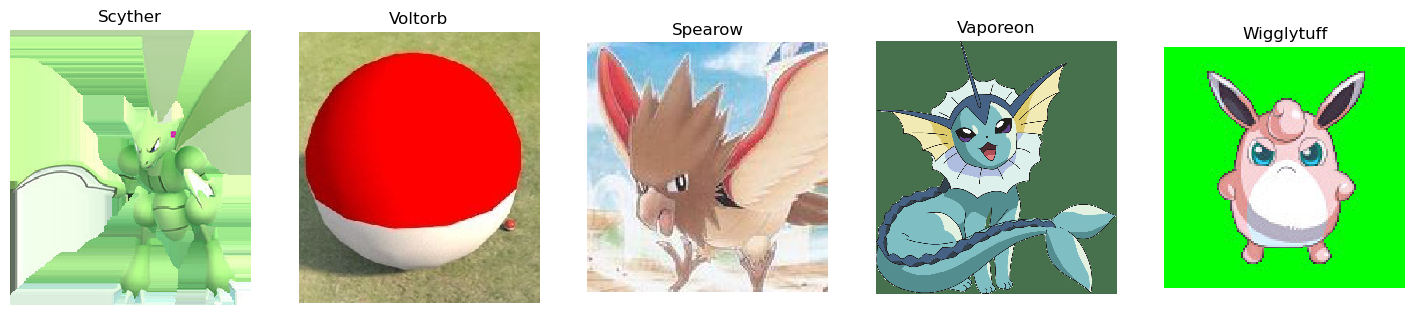

In [4]:
# 看target data
titles = ['Scyther', 'Voltorb', 'Spearow', 'Vaporeon', 'Wigglytuff']
example_files=[glob(f"target_support/{i}/*.jpg")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

In [5]:
np.random.seed(5566)
# 自己將source dataset依照class切成兩半，供自己驗證
all_classes = glob('source/*')
C=80
src_cls=np.random.permutation(all_classes)
src_cls,val_cls=src_cls[:C],src_cls[C:]

In [10]:
## 將抽選的source classes資料移到source1這個資料夾
for c in src_cls:
    c_name=os.path.basename(c)
    os.makedirs('meta_source1',exist_ok=True)
    os.system(f"cp -rLf {c} source1/{c_name}")
## 將抽選的validation class資料移到val_support這個資料夾
for c in val_cls:
    c_name=os.path.basename(c)
    os.makedirs('meta_val_support',exist_ok=True)
    os.system(f"cp -rLf {c} val_support/{c_name}")
    
## 將val_support裡面資料又切成support跟query兩部分
np.random.seed(5566)
val_classes = glob('meta_val_support/*')
for class_dir in val_classes:
    label_name=os.path.basename(class_dir)
    # copy some pics to new dir
    label_pics=glob(os.path.join(class_dir,"*.jpg"))
    label_pics=np.random.choice(label_pics,size=15,replace=False)
    class_dir=os.path.join("meta_val_query",label_name)
    os.makedirs(class_dir,exist_ok = True)
    for f in label_pics:
        shutil.move(src=f, dst=class_dir)

In [15]:
import torchvision.transforms as tvt
import torchvision.datasets as tvds

train_transform = tvt.Compose([
    tvt.RandomHorizontalFlip(),
    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    tvt.RandomRotation(15, fill=(0,0,0)),
    # 最後轉成Tensor供model使用。
    tvt.ToTensor(),
    tvt.Resize((128,128))
])
test_transform = tvt.Compose([
    tvt.ToTensor(),
    tvt.Resize((128,128))
])

# 原本Source套用source的transform
source_dataset = tvds.ImageFolder('source', transform=train_transform)
# 切出的Source套用source的transform
source_dataset1 = tvds.ImageFolder('meta_source1', transform=train_transform)

# 切出的Val套用target的transform
val_support_dataset = tvds.ImageFolder('meta_val_support', transform=train_transform)
val_query_dataset = tvds.ImageFolder('meta_val_query', transform=test_transform)


# Target套用target的transform
target_support_dataset = tvds.ImageFolder('target_support', transform=test_transform)

In [7]:
from torch.utils import data as tud
from supp.fsl_dataset import FewShotSampler

In [26]:
from supp.fsl_dataset import MetaLearningDataset

WAYS=5
SHOTS=5
source_meta_dataset=MetaLearningDataset(source_dataset,source_dataset.classes,WAYS,SHOTS,100)
source_meta_dataset1=MetaLearningDataset(source_dataset1,source_dataset1.classes,WAYS,SHOTS,100)

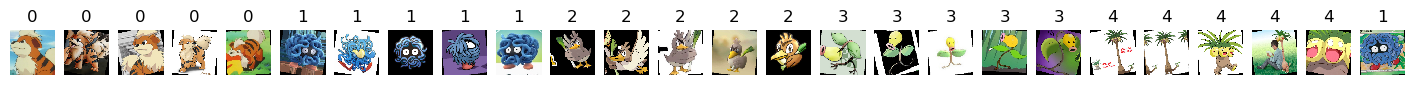

In [37]:
for x,y in source_meta_dataset1:
    break
show_data(x.detach().numpy().transpose(0,2,3,1),list(np.repeat(range(WAYS),SHOTS))+[y.detach().numpy()])

In [42]:
# source跟target都使用小batch size
BS_TRAIN=8
BS_TEST=16
source_meta_dataloader=tud.DataLoader(source_meta_dataset, 
                    batch_size=BS_TRAIN,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True)

source_meta_dataloader1=tud.DataLoader(source_meta_dataset1, 
                    batch_size=BS_TRAIN,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True)

val_query_dataloader=tud.DataLoader(val_query_dataset, 
                    batch_size=BS_TEST,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True)

## Meta Train

In [20]:
from torch import nn
from supp.nn_model import (FeatureExtractor,PrototypicalNet,cosine)

#@title Model Hyper Parameters for Prototypical Network
#@markdown Latent space dimension
latent_dims=64 #@param
#@markdown Model (meta learning): Prototypical Netwrok
backbone=FeatureExtractor(latent_features=latent_dims)
model=PrototypicalNet(WAYS,SHOTS,backbone,cosine).cuda()

In [21]:
from torch import nn
from supp.nn_model import (FocalLoss,AddMarginLoss,ArcMarginLoss)

#@title Loss (meta learning)
#@markdown export criterion=LossClass(*args)
loss_type="focal" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion = FocalLoss(gamma=9)
elif loss_type=="addmargin":
    criterion = AddMarginLoss(s=15.0, m=0.40,ways=WAYS,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion = ArcMarginLoss(s=32.0, m=0.40,ways=WAYS, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")

In [24]:
import torch.optim as optim
lr=1e-3
optimizer=optim.Adam(model.parameters(),lr=lr)

In [23]:
EPOCHS=15
# For scheduler
# scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [22]:
from tqdm.notebook import tqdm
def train_epoch(epoch,model,criterion,optimizer,dataloader,ismeta=True):
    running_loss = 0.0 # Feature Extrator & Label Predictor的loss
    total_hit, total_num = 0.0, 0.0 # total_hit: 計算目前對了幾筆 total_num: 目前經過了幾筆
    session=tqdm(enumerate(dataloader))
    for i, (data, label) in session:
        data = data.cuda()
        label = label.cuda()

        # 訓練整個model
        if ismeta:
            class_logits = model.meta_forward(data)
        else:
            class_logits=model(data)
        # loss以指定的為主
        loss = criterion(class_logits, label)
        loss.backward()

        optimizer.step()
        # scheduler.step(loss) # For scheduler
        optimizer.zero_grad()

        running_loss+= loss.item()
        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == label).item()
        total_num += data.shape[0]

        session.set_postfix({"epoch":epoch,"loss":loss.item(),"acc":total_hit / total_num})
    return running_loss / (i+1), total_hit / total_num

In [44]:
def run_test(model,data_loader,ismeta=True):
    result = dict(y_true=[],y_pred=[])
    total_test_hit, total_test_num = 0.0, 0.0
    with torch.no_grad():
        for i, (data,label) in enumerate(data_loader):
            test_data = data.cuda()
            test_label = label.cuda()
            
            if ismeta:
                class_logits = model.meta_forward(test_data)
            else:
                class_logits = model(test_data)
                
            pred = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
            result['y_true'].extend(label.cpu().detach().numpy())
            result['y_pred'].extend(pred)
            
            total_test_hit += torch.sum(torch.argmax(class_logits, dim=1) == test_label).item()
            total_test_num += test_data.shape[0]

    print("test acc:",total_test_hit / total_test_num)
    return result,total_test_hit / total_test_num

In [28]:
# 訓練 Source
try:
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(epoch,model,criterion,optimizer,source_meta_dataloader1,ismeta=True)
        torch.save(model.state_dict(), f'proto_{loss_type}.bin')
except KeyboardInterrupt:
    print("KeyboardInterrupt")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt


## Validation

In [38]:
from supp.fsl_dataset import FewShotSampler    
# 使用剛剛transfer learning的sampler 對target data進行sample 模擬N-way-k的情況
sampler=FewShotSampler(val_support_dataset,
                       classes=val_support_dataset.classes,
                       shots=SHOTS,repeats=1,shuffle=False) #注意這邊若是Metric Learning Shuffle要關掉

In [39]:
# 然後把每個用stack疊起來多一個rank，大小變成[TGT_WAYS*TGT_SHOTS,CH,W,H]
val_support_x=torch.stack([val_support_dataset[idx][0] for idx in sampler])
# 把y也拿起來做對照 (這邊只是對照而已後面用不到)
val_support_y=np.array([val_support_dataset[idx][1] for idx in sampler])

In [41]:
backbone.eval()
# 將n-way-k-shot的support data形成prototype以供inference
model.save_prototypes(val_support_x.cuda())

In [45]:
model.eval()
pred,acc=run_test(model,val_query_dataloader,ismeta=False)

test acc: 0.2045977011494253


## Mix Togather and Meta-Train Again

In [47]:
#@title Model Hyper Parameters for Prototypical Network
#@markdown Latent space dimension
latent_dims=64 #@param
#@markdown Model (meta learning): Prototypical Netwrok
backbone=FeatureExtractor(latent_features=latent_dims)
model=PrototypicalNet(WAYS,SHOTS,backbone,cosine).cuda()

#@title Loss (meta learning)
#@markdown export criterion=LossClass(*args)
loss_type="focal" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion = FocalLoss(gamma=9)
elif loss_type=="addmargin":
    criterion = AddMarginLoss(s=15.0, m=0.40,ways=WAYS,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion = ArcMarginLoss(s=32.0, m=0.40,ways=WAYS, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")
    
lr=1e-3
optimizer=optim.Adam(model.parameters(),lr=lr)

In [ ]:
# 訓練 Source
try:
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(epoch,model,criterion,optimizer,source_meta_dataloader,ismeta=True)
        torch.save(model.state_dict(), f'proto_{loss_type}.bin')
except KeyboardInterrupt:
    print("KeyboardInterrupt")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd96a1d040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd96a1d040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

# Adapt to target support

In [ ]:
WAYS4=len(['Scyther', 'Voltorb', 'Spearow', 'Vaporeon', 'Wigglytuff'])

In [26]:
from supp.fsl_dataset import FewShotSampler    
# 使用剛剛transfer learning的sampler 對target data進行sample 模擬N-way-k的情況
sampler=FewShotSampler(target_support_dataset,
                       classes=['Scyther', 'Voltorb', 'Spearow', 'Vaporeon', 'Wigglytuff'],
                       shots=SHOTS,repeats=1,shuffle=False) #注意這邊若是Metric Learning Shuffle要關掉

In [27]:
# 然後把每個用stack疊起來多一個rank，大小變成[TGT_WAYS*TGT_SHOTS,CH,W,H]
tgt_support_x=torch.stack([target_dataset[idx][0] for idx in sampler])
# 把y也拿起來做對照 (這邊只是對照而已後面用不到)
tgt_support_y=np.array([target_dataset[idx][1] for idx in sampler])

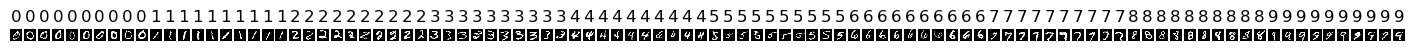

In [28]:
show_data(tgt_support_x.detach().numpy().transpose(0,2,3,1),tgt_support_y)

In [101]:
backbone.eval()
# 將n-way-k-shot的support data形成prototype以供inference
model.save_prototypes(tgt_support_x.cuda())

In [ ]:
target_support_dataloader=tud.DataLoader(target_support_dataset, 
                    batch_size=BS_TRAIN,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=False,
                    sampler=sampler2)

In [ ]:
model.eval()
pred,acc=run_test(model,target_support_dataloader,ismeta=False)

In [104]:
import pandas as pd
test_df=pd.read_csv('SampleSubmission.csv')
filenames=['target_query/'+v for v in test_df.filename.values]

In [105]:
import PIL
outputs=[*map(test_transform,map(PIL.Image.open,np.array(filenames)))]
target_query_dataloader=tud.DataLoader(outputs, 
                    batch_size=BS_TRAIN,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=False)

In [106]:
pred=[]
with torch.no_grad():
    for data in target_query_dataloader:
        test_data = data.cuda()
        class_logits = model(test_data)
        pred.extend(torch.argmax(class_logits, dim=1).cpu().detach().numpy())
test_df['ans']=pred
test_df.to_csv('baseline_meta.csv',index=False)